In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/updatedmarinedata/updatedMarineData.csv
/kaggle/input/marinedata/validation_set_winter.csv
/kaggle/input/marinedata/training_set.csv
/kaggle/input/marinedata/validation_set_summer.csv


# Vectorization of the data
import pandas as pd
data = pd.read_csv("/kaggle/input/marinedata/training_set.csv")
data.drop(columns="Unnamed: 0", inplace=True)
data.head()

# forumla to convert heading into a unit vector
# (sine(heading), cos(heading))
# then you can multiply by speed for a more accurate picture of 
# what the vector is doing
import numpy as np
heading = 0
def HeadingToVector(heading):
    vectorX = np.sin(heading * np.pi / 180)
    vectorY = np.cos(heading * np.pi / 180)
    # Fix floating point errors
    if(vectorX < 0.00001 and vectorX > -0.00001):
        vectorX = 0
    if(vectorY < 0.00001 and vectorY > -0.00001):
        vectorY = 0
    return (vectorX, vectorY)

HeadingToVector(heading)

data["VelocityX"] = 0
data["VelocityY"] = 0

data.head()

In [4]:
#for index, row in data.iterrows():
#    data.loc[index, "VelocityX"] = HeadingToVector(row["heading"])[0]
#    data.loc[index, "VelocityY"] = HeadingToVector(row["heading"])[1]

In [5]:
#data.to_csv('updatedMarineData.csv',index=False)
#data.head()

In [6]:
data = pd.read_csv("/kaggle/input/updatedmarinedata/updatedMarineData.csv")

/tmp/ipykernel_33/241266904.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/kaggle/input/updatedmarinedata/updatedMarineData.csv")


In [7]:
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

data2 = data.loc[:, ("timestamp", "mmsi", "lat", "lon", "speed", "heading")]
data2.dropna(inplace=True)

dataIF = data2.loc[:, ("lat", "lon", "speed", "heading")]

# My anomalies
anomalies = [[200, 150, 4, 100], [55, 9, 272, 259]]
dataIF = np.vstack([dataIF, anomalies])



In [39]:
from sklearn.model_selection import train_test_split
X = data2[["lat", "lon", "speed", "heading"]]
y = data2[["timestamp", "mmsi"]]
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.9, random_state=42) # too much data, chunk off most of it to testing
X_train, X_test, y_train, y_test = train_test_split(
    X_train2, y_train2, test_size=0.33, random_state=42)


In [40]:
print(data2.size)
print(X_train.shape[0])
print(y_train.shape[0])
print(2765698 * 3)

82970946
926508
926508
8297094


# Initialize and fit the Isolation Forest model
clf = IsolationForest(contamination=0.001, n_jobs= -1, random_state=42)  # Adjust contamination parameter as needed
clf.fit(X_train)

# Predict whether each data point is an anomaly (1 for inliers, -1 for outliers)
predictions = clf.predict(X_test)

# Visualize the results (lat and lon only)
#plt.scatter(dataIF[:, 0], dataIF[:, 1], c=predictions, cmap='viridis')
#plt.colorbar(label="Anomaly Score")
#plt.title("Anomaly Detection using Isolation Forest")
#plt.show()

# Identify anomalies (outliers)
#anomalies_indices = np.where(predictions == -1)[0]
#print("Detected anomalies:", anomalies_indices)

numToPrint = 5
print(predictions.size)
for i in predictions:
    # if anomalous, print
    if(predictions[i] == -1):
        if numToPrint > 0:
            numToPrint -= 1
            print("yes")
            print(data.iloc[i, :])
        else:
            break

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Generate a synthetic dataset with anomalies
#np.random.seed(42)
#normal_data = np.random.randn(300, 10)
#anomalies = 4 + 1.5 * np.random.randn(10, 10)  # Generating anomalies far from normal data

# Combine normal and anomaly data
#data = np.vstack([normal_data, anomalies])

# Build an autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 5  # Adjust the bottleneck layer size as needed

model = keras.Sequential([
    keras.layers.Input(shape=(input_dim,)),
    keras.layers.Dense(encoding_dim, activation='relu'),
    keras.layers.Dense(input_dim, activation='linear')  # Linear activation for reconstruction
])

model.compile(optimizer='adam', loss='mse')

# Train the autoencoder
model.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True)

# Calculate reconstruction errors
reconstructed_data = model.predict(X_train)
reconstruction_errors = np.mean(np.square(X_train - reconstructed_data), axis=1)

# Set a threshold for anomaly detection (e.g., using a percentile)
threshold = np.percentile(reconstruction_errors, 95)  # Adjust the percentile as needed

# Identify anomalies based on the threshold
anomalies_indices = np.where(reconstruction_errors > threshold)[0]
print("Detected anomalies:", anomalies_indices)

2024-06-11 08:04:09.980749: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 08:04:09.980916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 08:04:10.209823: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/10
28954/28954 ━━━━━━━━━━━━━━━━━━━━ 44s 1ms/step - loss: 1436.7538
Epoch 2/10
28954/28954 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step - loss: 2.5259
Epoch 3/10
28954/28954 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 2.5052
Epoch 4/10
28954/28954 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 2.4800
Epoch 5/10
28954/28954 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 2.4375
Epoch 6/10
28954/28954 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step - loss: 2.3587
Epoch 7/10
28954/28954 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 2.1909
Epoch 8/10
28954/28954 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 1.9009
Epoch 9/10
28954/28954 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 1.5551
Epoch 10/10
28954/28954 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 1.2932
28954/28954 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step
Detected anomalies: [     6     11     38 ... 926459 926490 926497]


In [10]:
arrayIDs = []
for i in anomalies_indices:
    arrayIDs.append(y_train.iloc[i]["mmsi"]) # grabs mmsi

In [11]:
arrIDs = pd.DataFrame(arrayIDs)
print(arrIDs.size)
print(arrIDs.value_counts())

46326
0        
230660000    1213
230108490    1017
257053700     842
235102029     387
230916000     374
             ... 
235192000       1
235095979       1
235087214       1
248075000       1
205366000       1
Name: count, Length: 1217, dtype: int64


In [12]:
anomaly = data.loc[data["mmsi"] == 257053700]
anomaly.head()

,timestamp,mmsi,lat,lon,speed,course,heading,turnrate,breadth,vessel_type,vessel_max_speed,draft,power,dwt,iceclass,VelocityX,VelocityY
14046451,2017-11-01 09:16:31,257053700,59.425660,10.483242,0.0,277.3,326.0,0.0,9.81,PAS,NaN,3.8,460.0,0.0,II,0.0,0.0
14046452,2017-11-01 09:46:34,257053700,59.425673,10.483245,0.0,329.3,327.0,0.0,9.81,PAS,NaN,3.8,460.0,0.0,II,0.0,0.0
14046453,2017-11-01 10:22:33,257053700,59.425687,10.483255,0.0,257.7,327.0,0.0,9.81,PAS,NaN,3.8,460.0,0.0,II,0.0,0.0
14046454,2017-11-01 10:52:33,257053700,59.425653,10.483213,0.0,356.9,328.0,0.0,9.81,PAS,NaN,3.8,460.0,0.0,II,0.0,0.0
14046455,2017-11-01 11:22:32,257053700,59.425653,10.483268,0.0,6.4,327.0,0.0,9.81,PAS,NaN,3.8,460.0,0.0,II,0.0,0.0


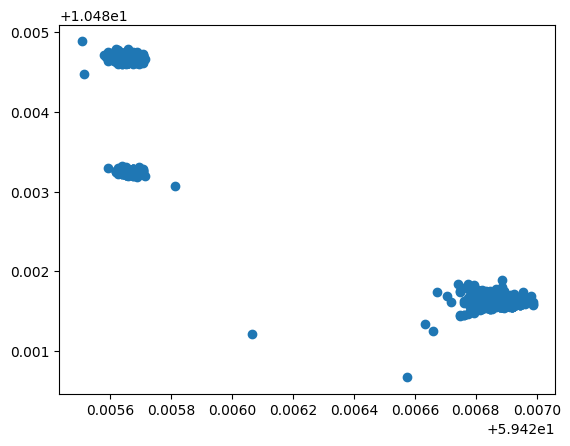

In [13]:
import matplotlib.pyplot as plt

x = anomaly["lat"]
y = anomaly["lon"]
plt.scatter(x, y)
plt.show()

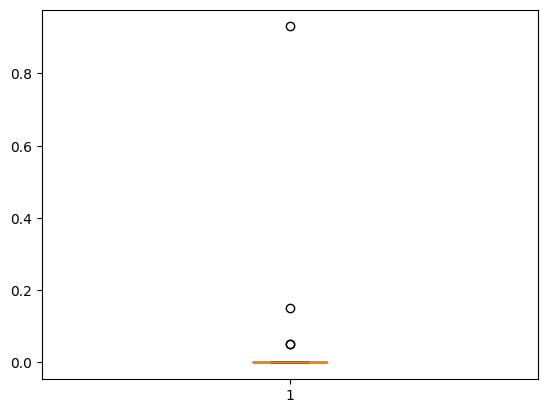

In [14]:
# Create the box and whiskers (boxplot)
plt.boxplot(anomaly["speed"])
plt.show()

In [15]:
anomaly = data.loc[data["mmsi"] == 220609000]
anomaly.head()

,timestamp,mmsi,lat,lon,speed,course,heading,turnrate,breadth,vessel_type,vessel_max_speed,draft,power,dwt,iceclass,VelocityX,VelocityY
4262583,2017-11-01 09:13:14,220609000,57.692667,11.823000,0.00,86.0,191.0,0.00,14.6,T,11.6,5.41,1920.0,3522.0,II,0.0,0.0
4262584,2017-11-01 09:43:14,220609000,57.692713,11.823050,0.00,308.0,191.0,1.12,14.6,T,11.6,5.41,1920.0,3522.0,II,0.0,0.0
4262585,2017-11-01 10:13:15,220609000,57.692680,11.823055,0.00,70.0,191.0,0.00,14.6,T,11.6,5.41,1920.0,3522.0,II,0.0,0.0
4262586,2017-11-01 10:49:15,220609000,57.692667,11.823000,0.00,306.0,191.0,0.00,14.6,T,11.6,5.41,1920.0,3522.0,II,0.0,0.0
4262587,2017-11-01 11:04:38,220609000,57.689167,11.823000,1.29,157.0,160.0,0.00,14.6,T,11.6,5.41,1920.0,3522.0,II,0.0,0.0


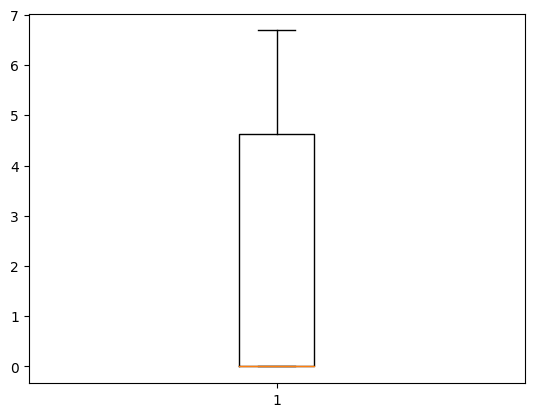

In [16]:
# Create the box and whiskers (boxplot)
plt.boxplot(anomaly["speed"])
plt.show()

Evaluate Silhouette Score to see if model is a good fit for determining anomalyous data. Score of -1 is bad, 1 is good.

In [41]:
y_train["Anomaly"] = 0
for i in anomalies_indices:
    y_train.iloc[i, y_train.columns.get_loc("Anomaly")] = 1

In [42]:
print(X_train.shape[0])
print(y_train.shape[0])

926508
926508


In [43]:
from sklearn.metrics import silhouette_score
silScore = silhouette_score(X_train, y_train["Anomaly"])

print(silScore)

KeyboardInterrupt: 